Note my python version:

In [1]:
import sys
print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


Packages you'll need:

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.graphics.mosaicplot import mosaic

# Is there a relation?

Read the okcupid dataset:

In [77]:
okcupid = pd.read_csv('data/okcupid.csv')

In [15]:
okcupid.head()

,age,drugs,ethnicity,height,income,orientation,sex,status
0,22,never,other,190.50,-1,straight,m,single
1,35,sometimes,white,177.80,80000,straight,m,single
2,38,NaN,other,172.72,-1,straight,m,single
3,23,NaN,white,180.34,20000,straight,m,single
4,29,never,other,167.64,-1,straight,m,single


In [16]:
print('n rows: %d, n columns: %d' % okcupid.shape)

n rows: 59946, n columns: 8


Is there a relation between age and height (say, for adult women)?

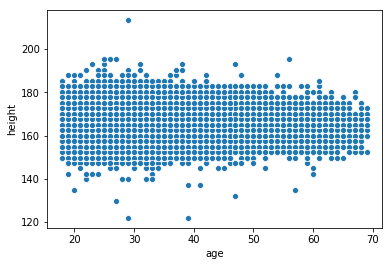

In [82]:
okcupid_fil = okcupid[(okcupid['sex'] == 'f') & (okcupid['age'] < 80) & (okcupid['height'] > 120) & (okcupid['height'] < 220)]

g = sns.scatterplot(x = 'age', y = 'height', data = okcupid_fil)

In [83]:
r, p_val = st.pearsonr(okcupid_fil['age'], okcupid_fil['height'])
print('Pearson r: %.2f, P-value: %.2f' % (r, p_val))

Pearson r: 0.00, P-value: 0.90


Is there a relation between ethnicity and (reported) drug abuse?

In [81]:
eth_type = pd.api.types.CategoricalDtype(categories = ['white', 'black', 'latin', 'asian', 'other'], ordered=True)
okcupid['ethnicity'] = okcupid['ethnicity'].astype(eth_type)

drug_type = pd.api.types.CategoricalDtype(categories = ['never', 'sometimes', 'often'], ordered=True)
okcupid['drugs'] = okcupid['drugs'].astype(drug_type)

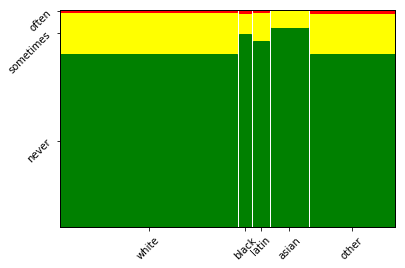

In [33]:
props = {}
for x in eth_type.categories:
    for y, col in zip(drug_type.categories, ['green', 'yellow', 'red']):
        props[(x, y)] ={'color': col}

mosaic(okcupid, ['ethnicity', 'drugs'], labelizer=lambda k: '', properties=props, label_rotation=45)
plt.show()

In [47]:
pd.crosstab(okcupid['ethnicity'], okcupid['drugs'], margins=True)

drugs,never,sometimes,often,All
ethnicity,,,,
white,19860,4693,206,1711
black,1531,159,21,11909
latin,1994,298,20,2312
asian,4790,373,12,5175
other,9549,2209,151,24759
All,37724,7732,410,45866


In [72]:
conf_mat_per = pd.crosstab(okcupid['ethnicity'], okcupid['drugs'], normalize='index')
format_dict = {label: '{:,.1%}'.format for label in drug_type.categories}
conf_mat_per.style.format(format_dict)

drugs,never,sometimes,often
ethnicity,,,
white,80.2%,19.0%,0.8%
black,89.5%,9.3%,1.2%
latin,86.2%,12.9%,0.9%
asian,92.6%,7.2%,0.2%
other,80.2%,18.5%,1.3%


In [57]:
# adapted from SO: https://stackoverflow.com/questions/45020538/how-to-apply-cramer-v-on-2x2-matrix
def cramers_v(confusion_matrix):
    chi2, pval = st.chi2_contingency(confusion_matrix, correction=False)[:2]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1))), pval

cv, pval = cramers_v(pd.crosstab(okcupid['ethnicity'], okcupid['drugs']))
print('Cramer\'s V: %.2f, P-value: %.2f' % (cv, pval))

Cramer's V: 0.08, P-value: 0.00


Is there a relation between sexual orientation and height?

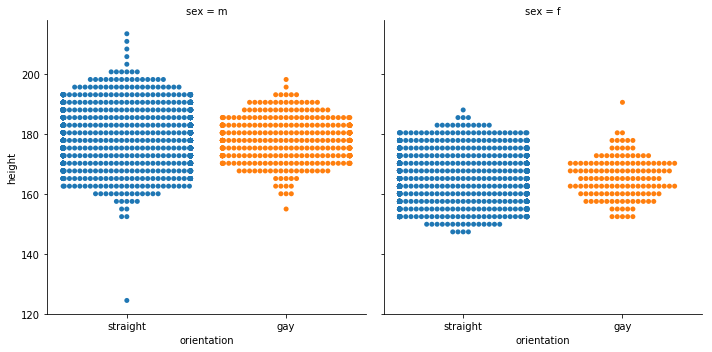

In [102]:
okcupid_fil = okcupid[(okcupid['height'] > 120) & (okcupid['height'] < 220) & (okcupid['orientation'].isin(['straight', 'gay']))]

g = sns.catplot(x='orientation', y='height', col='sex', kind='swarm', data=okcupid_fil.sample(5000))

In [119]:
sum_table = okcupid_fil.groupby(['sex', 'orientation'], as_index=False)['height'].agg({'mean': 'mean', 'std': 'std'})
format_dict = {label: '{:,.1f}'.format for label in ['mean', 'std']}
sum_table.style.format(format_dict)

,sex,orientation,mean,std
0,f,gay,165.4,7.1
1,f,straight,165.3,7.0
2,m,gay,178.0,7.3
3,m,straight,179.1,7.3


In [94]:
straight_height_m = okcupid_fil[(okcupid_fil['orientation'] == 'straight') & (okcupid_fil['sex'] == 'm')]['height']
straight_height_f = okcupid_fil[(okcupid_fil['orientation'] == 'straight') & (okcupid_fil['sex'] == 'f')]['height']
gay_height_m = okcupid_fil[(okcupid_fil['orientation'] == 'gay') & (okcupid_fil['sex'] == 'm')]['height']
gay_height_f = okcupid_fil[(okcupid_fil['orientation'] == 'gay') & (okcupid_fil['sex'] == 'f')]['height']

t_m, pval_m = st.ttest_ind(straight_height_m, gay_height_m)
t_f, pval_f = st.ttest_ind(straight_height_f, gay_height_f)

print('Men - Student\'s t: %.2f, P-value: %.2f' % (t_m, pval_m))
print('Women - Student\'s t: %.2f, P-value: %.2f' % (t_f, pval_f))

Men - Student's t: 9.01, P-value: 0.00
Women - Student's t: -0.19, P-value: 0.85


What is the relation between height and income?

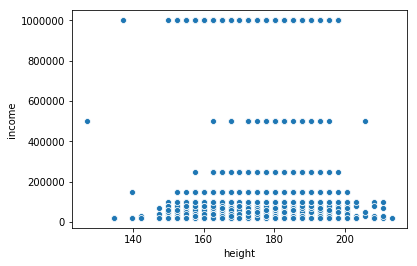

In [120]:
okcupid_fil = okcupid[(okcupid['height'] > 120) & (okcupid['height'] < 220) & (okcupid['income'] > 0)]

g = sns.scatterplot(x = 'height', y = 'income', data = okcupid_fil)

Text(0.5, 1.0, 'sex = f')

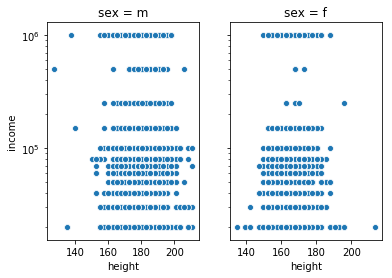

In [140]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
g1 = sns.scatterplot(x = 'height', y = 'income', data = okcupid_fil[okcupid_fil['sex'] == 'm'], ax = ax1)
g1.set(yscale = 'log')
g1.set_title('sex = m')
g2 = sns.scatterplot(x = 'height', y = 'income', data = okcupid_fil[okcupid_fil['sex'] == 'f'], ax = ax2)
g2.set(yscale = 'log')
g2.set_title('sex = f')